## Task 3 - Explore interesting characteristics of the development data set
Be creative. This is real-world environmental data. What is interesting about it to you? What features are surprising or exhibit characteristics that may cause issues when used in modeling? Select a subset of features that exhibit such a characteristic and explore it further (be prepared to discuss your findings).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import logging

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

In [86]:
cd = os.getcwd()
parent = os.path.dirname(cd)
data_folder = os.path.join(parent, 'data')

data = pd.read_csv(os.path.join(data_folder, 'dev.csv'))
data
#converting the date column to datetime
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])

In [87]:
print(data.columns)

Index(['datetime_utc', 'wtempc', 'atempc', 'winddir_dcfn', 'precp_in',
       'relh_pct', 'spc', 'dox_mgl', 'ph', 'windgust_knots', 'wse1988',
       'wvel_fps', 'mbars', 'windspeed_knots', 'par', 'turb_fnu'],
      dtype='object')


## Interested in the Precipitation Field. Starting to wonder if there were any big storms this year

Let's take a look at it and start to get a picture.
- First clean up the field by finding the null values, removing them if it is a small percentage of the data
- Then look at the stats of the remaining data


In [88]:
#check for missing values in precp_in
data['precp_in'].isnull().sum()
precipt = data[['datetime_utc', 'precp_in']]
precipt = precipt.set_index('datetime_utc')
precipt.dropna(inplace=True)



Looking at the distribution of all rainfall. 

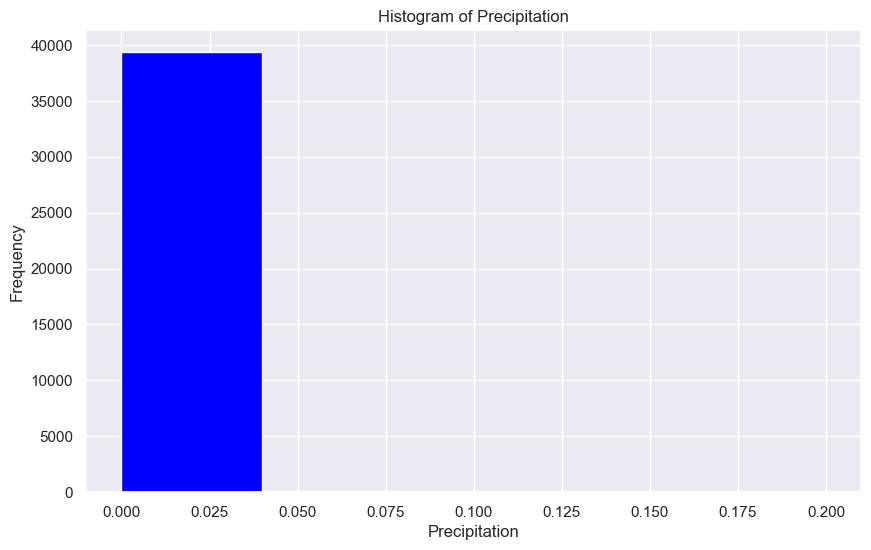

In [91]:
#plot histogram 
sns.set()
plt.figure(figsize=(10, 6))
plt.hist(precipt['precp_in'], bins=5, color='blue')    
plt.title('Histogram of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()


With the small time step for reporting, the precip values will be close to 0. This makes it difficult to differentiate rain from no rain from the above histogram.

Since we're interested in rain, let's try to make a dataset of rainfall events. To start, we can filter out the dataset of rows with no rainfall, then plot that distribution.

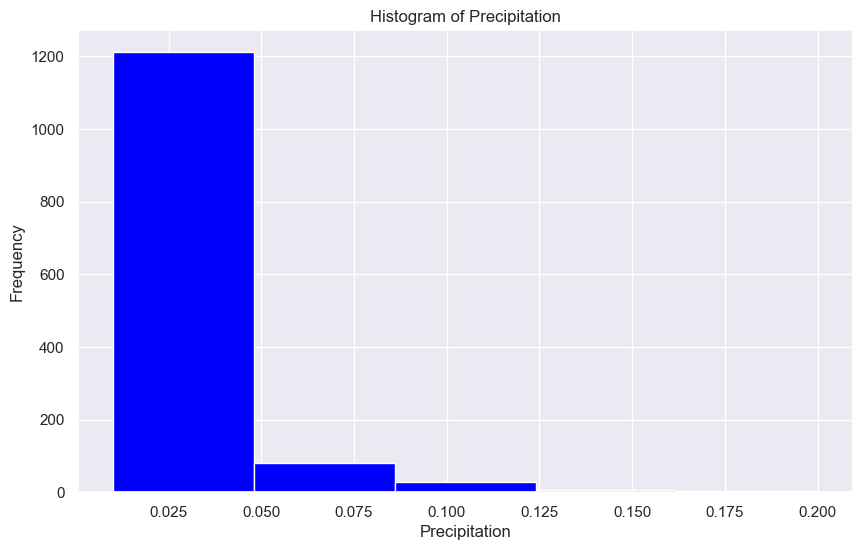

In [92]:
precip_nonzero = precipt[precipt['precp_in'] > 0]
plt.figure(figsize=(10, 6))
plt.hist(precip_nonzero['precp_in'], bins=5, color='blue')
plt.title('Histogram of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()



Still very skewed to the left, makes sense. Now let's try to group each event together by looking for where the rainfall goes from off to on and marking that as a switch in the state. 
 - *Bool of whether or not rain was measure for each row*
 - *Convert True/False to int*
 - *Calculate differences of consecutive rows. This IDs when there is a change in state*
 - *ID each event by summing the state changes*

Make new row to precip so we can ID the start and stop of each event
 - This will be used later


In [93]:
# Step 1: Create a boolean Series where precipitation > 0
is_raining = precipt['precp_in'] > 0
print(is_raining)
# Step 2: Convert the boolean values to integers (True -> 1, False -> 0)
raining_int = is_raining.astype(int)
print(raining_int)
# Step 3: Calculate the difference between consecutive values
diff_rain = raining_int.diff()
print(diff_rain)

# Step 4: Check for changes in state (not equal to 0)
state_change = diff_rain.ne(0)
print(state_change)
# Step 5: Create a cumulative sum to generate unique event IDs
precipt['event'] = state_change.cumsum()


datetime_utc
2023-01-02 00:00:00    False
2023-01-02 00:15:00    False
2023-01-02 00:30:00    False
2023-01-02 00:45:00    False
2023-01-02 01:00:00    False
                       ...  
2024-02-19 22:45:00    False
2024-02-19 23:00:00    False
2024-02-19 23:15:00    False
2024-02-19 23:30:00    False
2024-02-19 23:45:00    False
Name: precp_in, Length: 39548, dtype: bool
datetime_utc
2023-01-02 00:00:00    0
2023-01-02 00:15:00    0
2023-01-02 00:30:00    0
2023-01-02 00:45:00    0
2023-01-02 01:00:00    0
                      ..
2024-02-19 22:45:00    0
2024-02-19 23:00:00    0
2024-02-19 23:15:00    0
2024-02-19 23:30:00    0
2024-02-19 23:45:00    0
Name: precp_in, Length: 39548, dtype: int32
datetime_utc
2023-01-02 00:00:00    NaN
2023-01-02 00:15:00    0.0
2023-01-02 00:30:00    0.0
2023-01-02 00:45:00    0.0
2023-01-02 01:00:00    0.0
                      ... 
2024-02-19 22:45:00    0.0
2024-02-19 23:00:00    0.0
2024-02-19 23:15:00    0.0
2024-02-19 23:30:00    0.0
2024-02-19

In [113]:
#print the whole dataframe to the console
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(precipt)



                     precp_in  event
datetime_utc                        
2023-03-14 12:00:00      0.01    278
2023-03-14 12:15:00      0.02    278
2023-03-14 12:30:00      0.03    278
2023-03-14 12:45:00      0.03    278
2023-03-14 13:00:00      0.03    278
2023-03-14 13:15:00      0.03    278
2023-03-14 13:30:00      0.03    278
2023-03-14 13:45:00      0.03    278
2023-03-14 14:00:00      0.04    278
2023-03-14 14:15:00      0.03    278
2023-03-14 14:30:00      0.04    278
2023-03-14 14:45:00      0.03    278
2023-03-14 15:00:00      0.04    278
2023-03-14 15:15:00      0.04    278
2023-03-14 15:30:00      0.04    278
2023-03-14 15:45:00      0.03    278
2023-03-14 16:00:00      0.04    278
2023-03-14 16:15:00      0.05    278
2023-03-14 16:30:00      0.04    278
2023-03-14 16:45:00      0.04    278
2023-03-14 17:00:00      0.04    278
2023-03-14 17:15:00      0.04    278
2023-03-14 17:30:00      0.04    278
2023-03-14 17:45:00      0.04    278
2023-03-14 18:00:00      0.04    278
2

In [94]:
print(precipt)
len(precipt)
events_nonzero = precipt[precipt['precp_in'] > 0]
#get unique events
events = events_nonzero['event'].unique()
len(events)

                     precp_in  event
datetime_utc                        
2023-01-02 00:00:00       0.0      1
2023-01-02 00:15:00       0.0      1
2023-01-02 00:30:00       0.0      1
2023-01-02 00:45:00       0.0      1
2023-01-02 01:00:00       0.0      1
...                       ...    ...
2024-02-19 22:45:00       0.0    861
2024-02-19 23:00:00       0.0    861
2024-02-19 23:15:00       0.0    861
2024-02-19 23:30:00       0.0    861
2024-02-19 23:45:00       0.0    861

[39548 rows x 2 columns]


430

I will filter out any "event" definition to exclude events that last less than 6 hours. I want to see longer storm events only

In [95]:
#get rid of any events with less than 24 hours of rain
events_to_remove = []
for event in events:
    event_data = events_nonzero[events_nonzero['event'] == event]
    if len(event_data) < 24:
        events_to_remove.append(event)
events = [event for event in events if event not in events_to_remove]
print(events)
print(events_to_remove)
#get rid of the events that are less than 24 hours, remove events

precipt = precipt[precipt['event'].isin(events)]


[278, 382, 576, 630, 660, 680, 766]
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410, 4

It seems like we only have 7 storm events total in the data

In [96]:
print(precipt)
#get rid of precipitation values that are zero
precipt = precipt[precipt['precp_in'] > 0]


                     precp_in  event
datetime_utc                        
2023-03-14 12:00:00      0.01    278
2023-03-14 12:15:00      0.02    278
2023-03-14 12:30:00      0.03    278
2023-03-14 12:45:00      0.03    278
2023-03-14 13:00:00      0.03    278
...                       ...    ...
2024-01-10 05:30:00      0.03    766
2024-01-10 05:45:00      0.02    766
2024-01-10 06:00:00      0.01    766
2024-01-10 06:15:00      0.05    766
2024-01-10 06:30:00      0.03    766

[247 rows x 2 columns]


In [97]:
#GROUPBY EVENT 
event_groups = precipt.groupby('event')
event_durations = event_groups.size()  
event_durations.describe() 

count     7.000000
mean     35.285714
std      11.071198
min      24.000000
25%      28.500000
50%      33.000000
75%      38.000000
max      57.000000
dtype: float64

In [98]:
#making a list of dataframes for each event
events = event_groups.groups.keys() 
print(events)
event_dfs = []
for event in events:
    event_data = event_groups.get_group(event)
    event_data = event_data.rename(columns={'precp_in': f'event_{event}'})
    event_data = event_data.drop(columns=['event'])
    event_dfs.append(event_data)
    

dict_keys([278, 382, 576, 630, 660, 680, 766])


In [99]:
event_list = list(events)

In [100]:
sum(event_dfs[0][f"event_{event_list[0]}"])

1.2600000000000005

<Figure size 1000x600 with 0 Axes>

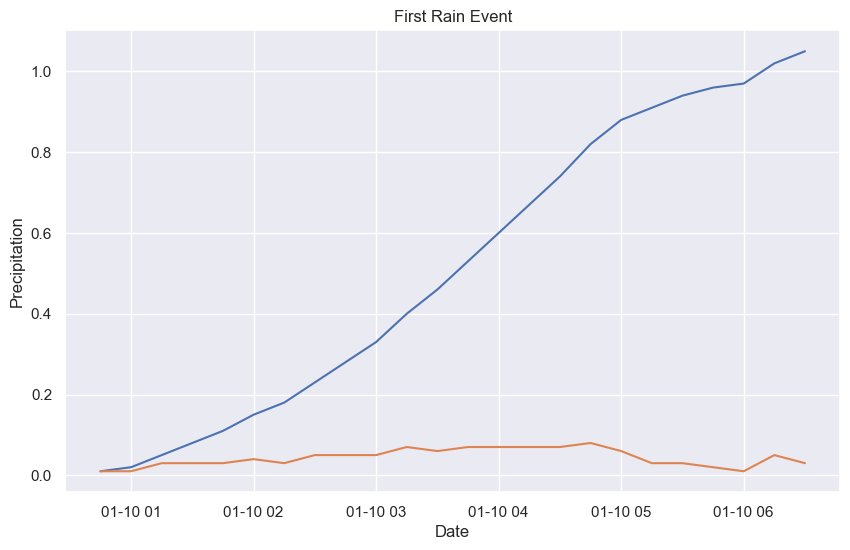

In [101]:
#plot the first event
event_data = event_dfs[6]
plt.figure(figsize=(10, 6))
#plot cumulated precipitation
plt.figure(figsize=(10, 6))
plt.plot(event_data.index, event_data[f'event_{list(events)[6]}'].cumsum())
plt.plot(event_data.index, event_data[f'event_{list(events)[6]}'])

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('First Rain Event')
plt.show()


In [102]:
event_timestamps = precipt.index
event_timestamps

DatetimeIndex(['2023-03-14 12:00:00', '2023-03-14 12:15:00',
               '2023-03-14 12:30:00', '2023-03-14 12:45:00',
               '2023-03-14 13:00:00', '2023-03-14 13:15:00',
               '2023-03-14 13:30:00', '2023-03-14 13:45:00',
               '2023-03-14 14:00:00', '2023-03-14 14:15:00',
               ...
               '2024-01-10 04:15:00', '2024-01-10 04:30:00',
               '2024-01-10 04:45:00', '2024-01-10 05:00:00',
               '2024-01-10 05:15:00', '2024-01-10 05:30:00',
               '2024-01-10 05:45:00', '2024-01-10 06:00:00',
               '2024-01-10 06:15:00', '2024-01-10 06:30:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=247, freq=None)

**Now let's look at how an event impacts the other features.**

**Or the other way around...**

We make two dataframes, one with all the data that has events, and one with all the data that does not have events (but maybe a little bit of rain)

Then we look at how this impacts the other features by looking for a shift in the distribution of features during wet and dry weather. Some of the features I think might be interesting would be:
- Turbidity. I would assume the turbidity would represent a higher mean during events than now
- Barometric Pressure. I would assume there would be a slight dip in the pressure during events since they are accompanied by frontal lows
- WSE. I would expect this to be positively correlated to events.


In [103]:
#create identifier for whether the data is part of the 7 events
data['event'] = 0
event_timestamps = list(event_timestamps)
#use the event_timestamps to set the event column to 1 when there is an event
data['event'] = data['datetime_utc'].isin(event_timestamps).astype(int)

In [104]:
data.columns

Index(['datetime_utc', 'wtempc', 'atempc', 'winddir_dcfn', 'precp_in',
       'relh_pct', 'spc', 'dox_mgl', 'ph', 'windgust_knots', 'wse1988',
       'wvel_fps', 'mbars', 'windspeed_knots', 'par', 'turb_fnu', 'event'],
      dtype='object')

In [105]:
#make new dfs for during events and not during events
all_event_data = data[data['event'] == 1]
all_non_event_data = data[data['event'] == 0]


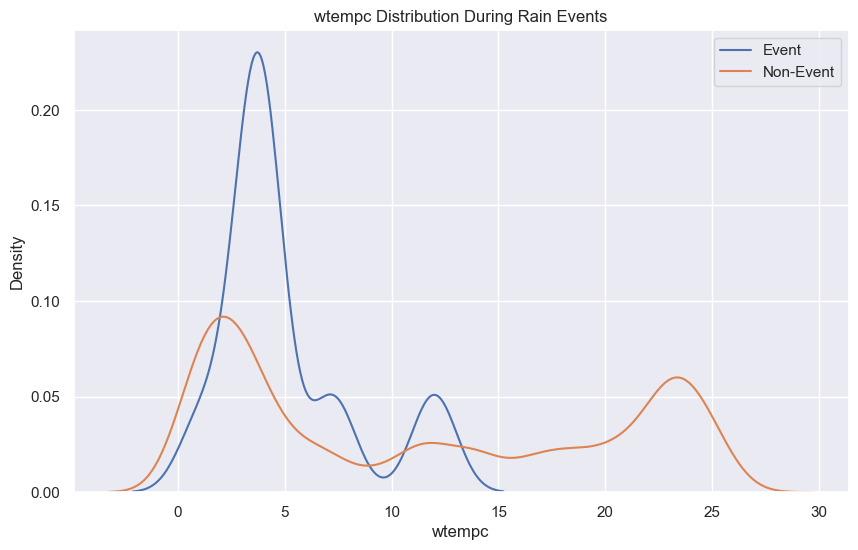

2024-10-16 17:39:59,610 - root - INFO - wtempc Distribution During Rain Events


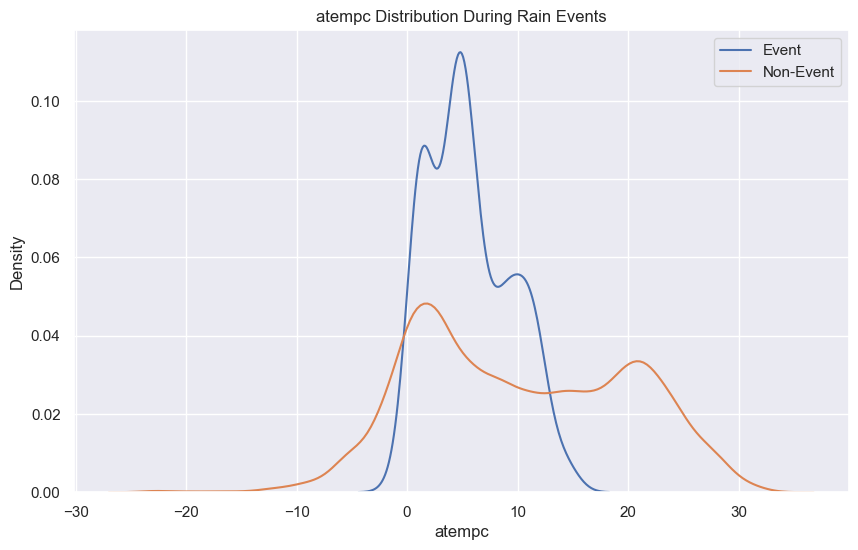

2024-10-16 17:40:00,300 - root - INFO - atempc Distribution During Rain Events


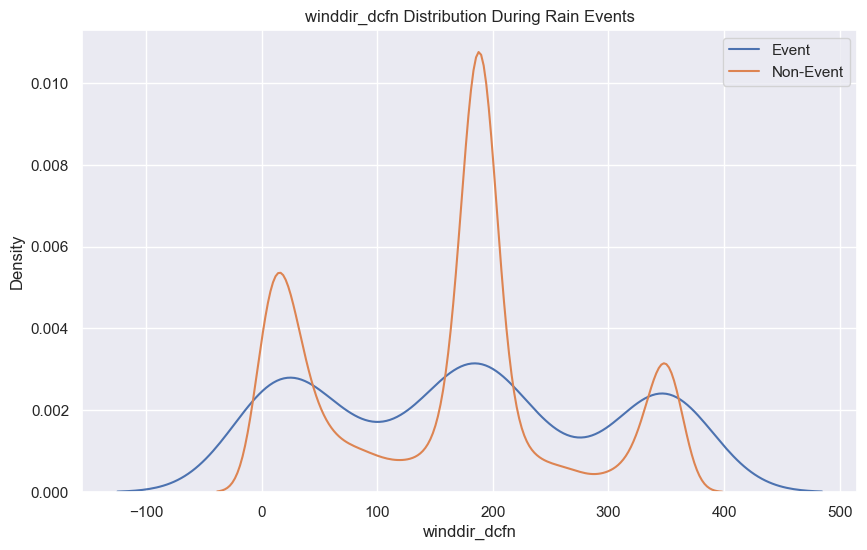

2024-10-16 17:40:00,975 - root - INFO - winddir_dcfn Distribution During Rain Events


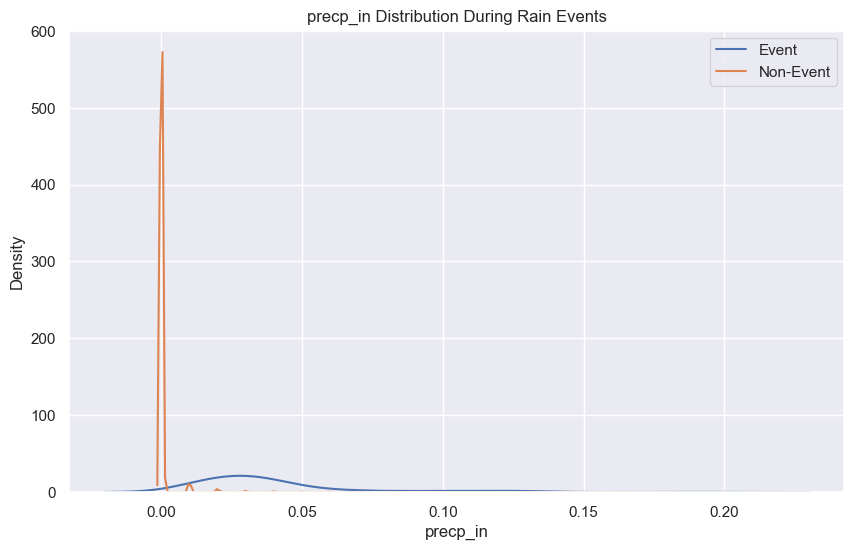

2024-10-16 17:40:01,232 - root - INFO - precp_in Distribution During Rain Events


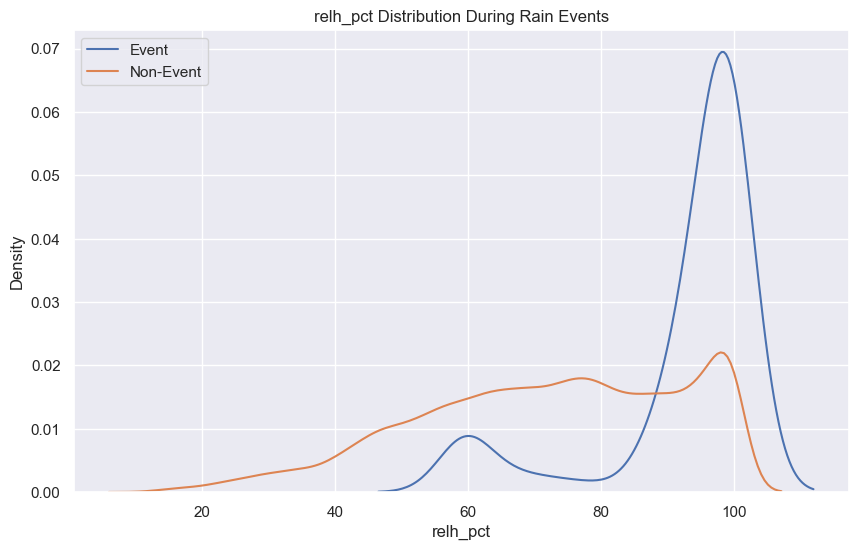

2024-10-16 17:40:01,685 - root - INFO - relh_pct Distribution During Rain Events


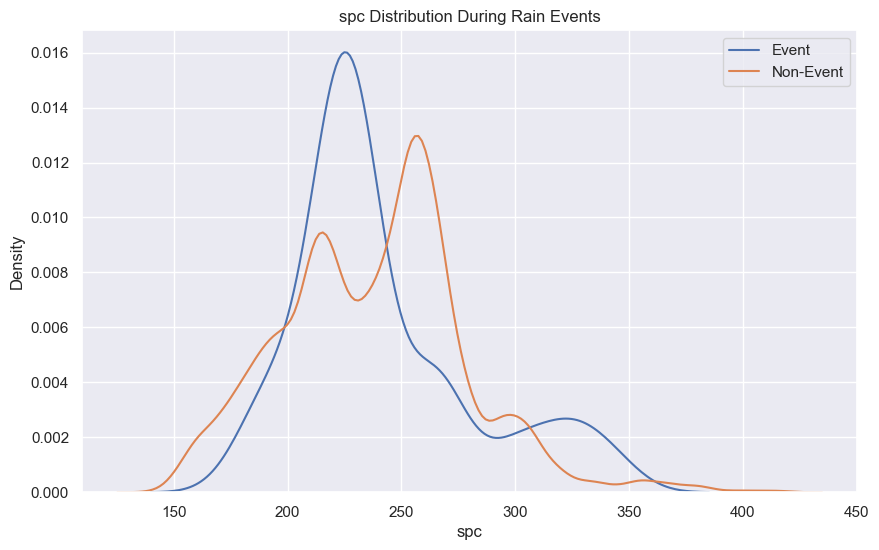

2024-10-16 17:40:02,247 - root - INFO - spc Distribution During Rain Events


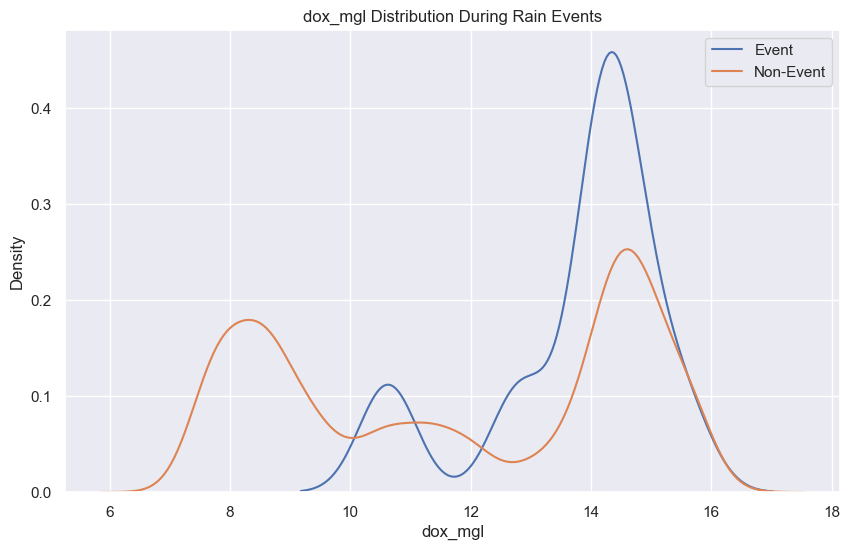

2024-10-16 17:40:02,754 - root - INFO - dox_mgl Distribution During Rain Events


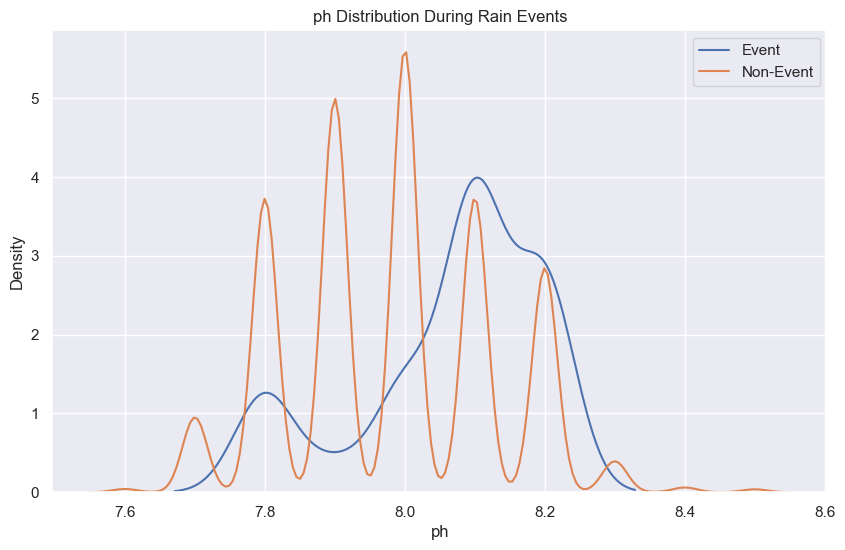

2024-10-16 17:40:03,333 - root - INFO - ph Distribution During Rain Events


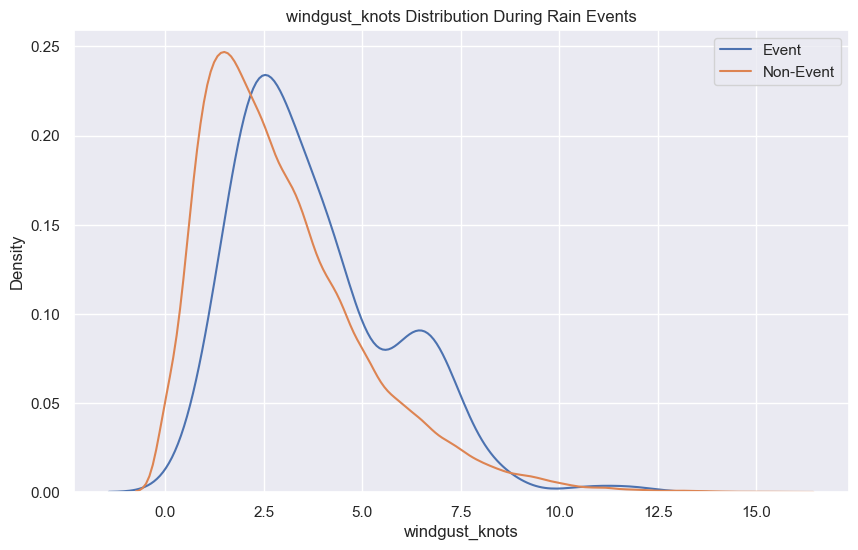

2024-10-16 17:40:03,786 - root - INFO - windgust_knots Distribution During Rain Events


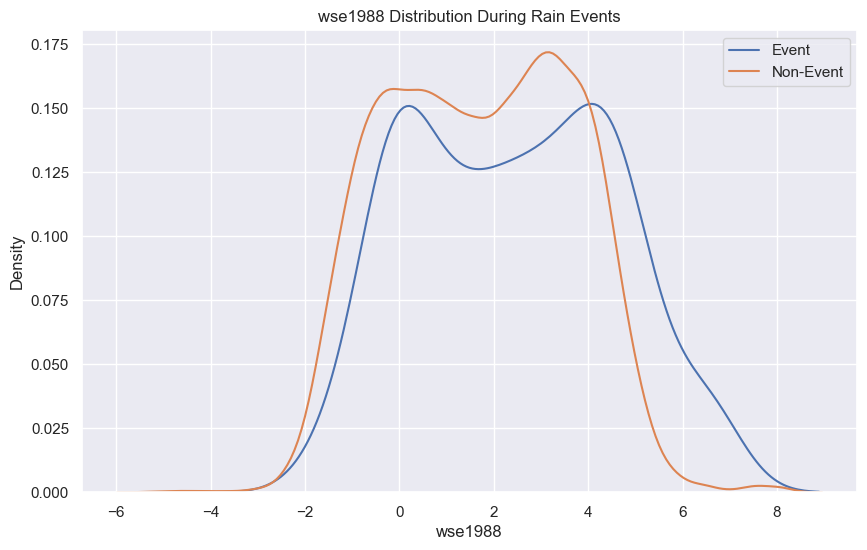

2024-10-16 17:40:04,336 - root - INFO - wse1988 Distribution During Rain Events


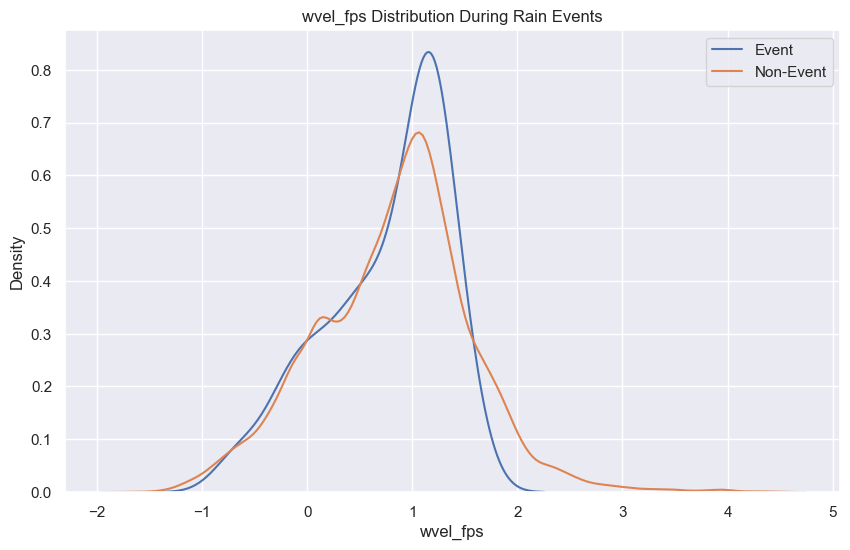

2024-10-16 17:40:04,854 - root - INFO - wvel_fps Distribution During Rain Events


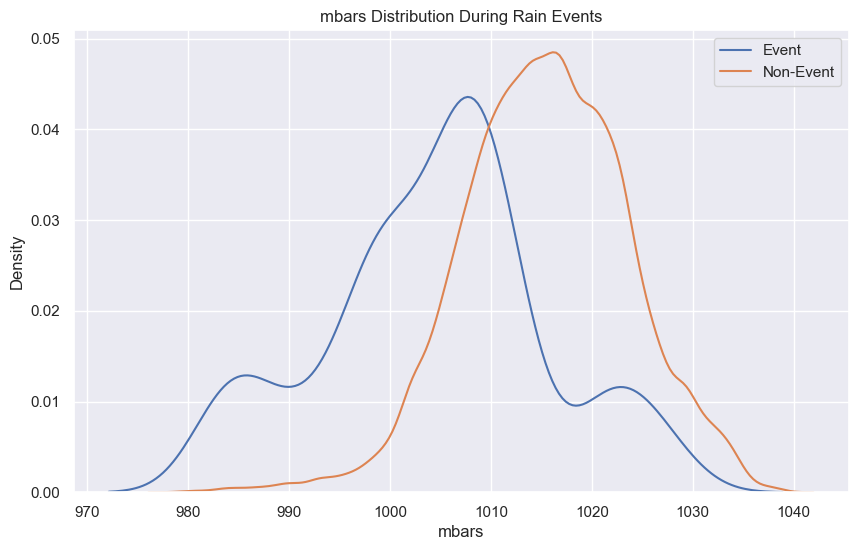

2024-10-16 17:40:05,370 - root - INFO - mbars Distribution During Rain Events


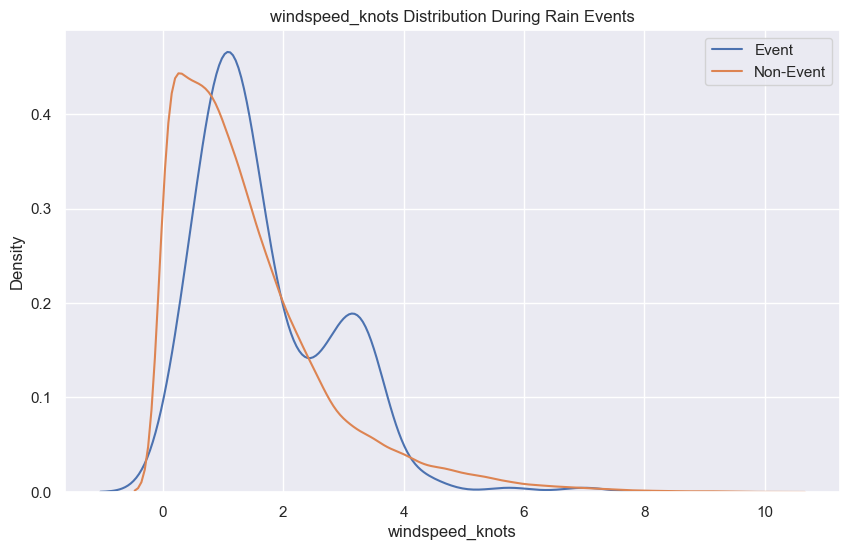

2024-10-16 17:40:05,860 - root - INFO - windspeed_knots Distribution During Rain Events


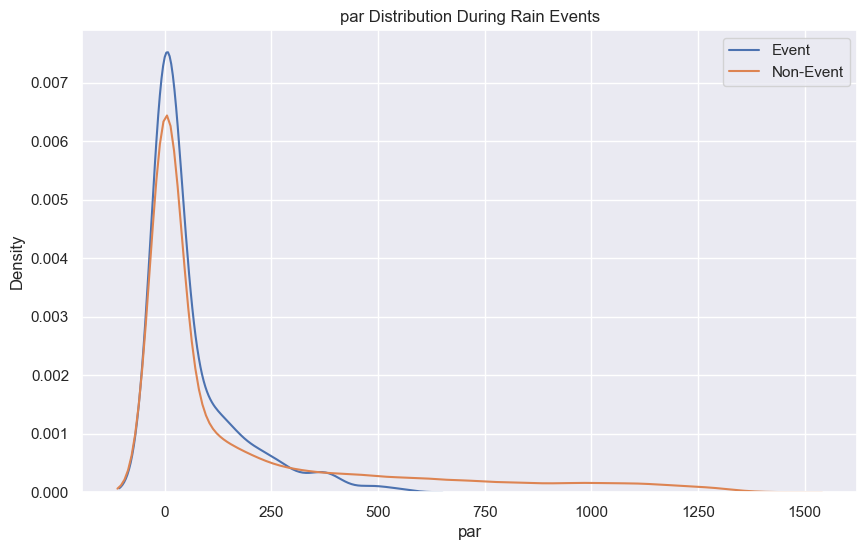

2024-10-16 17:40:06,386 - root - INFO - par Distribution During Rain Events


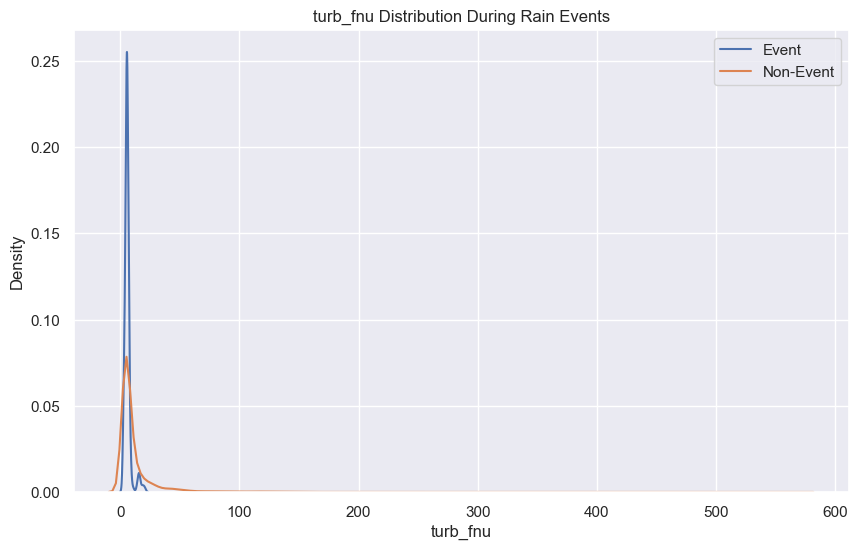

2024-10-16 17:40:06,702 - root - INFO - turb_fnu Distribution During Rain Events
C:\Users\dmccormick\AppData\Local\Temp\ipykernel_13316\3593450635.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_event_data[feature], label='Event')
C:\Users\dmccormick\AppData\Local\Temp\ipykernel_13316\3593450635.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_non_event_data[feature], label='Non-Event')
C:\Users\dmccormick\AppData\Local\Temp\ipykernel_13316\3593450635.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


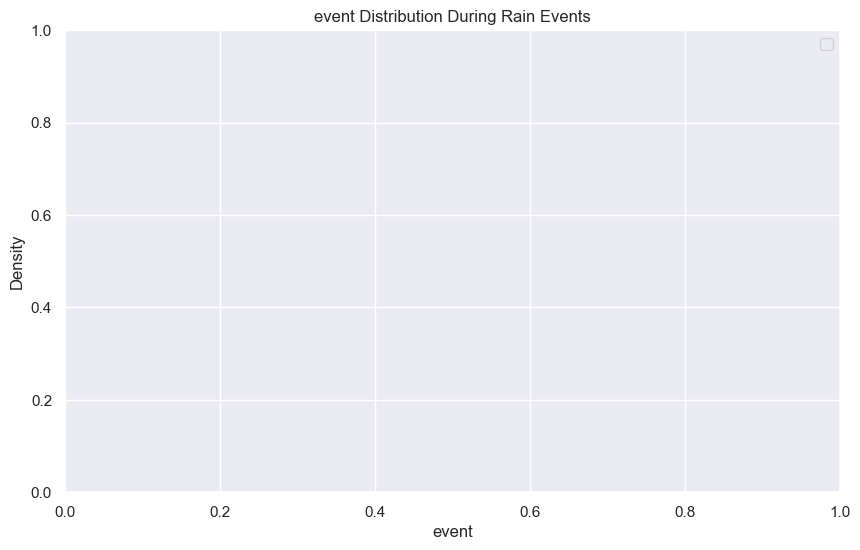

2024-10-16 17:40:06,869 - root - INFO - event Distribution During Rain Events


In [108]:
#plot the distributions of wse1988, mbars, and turb_fnu during events and not during events and add to the log
# features = ['wse1988', 'mbars', 'turb_fnu','wvel_fps', 'relh_pct','dox_mgl']
features = all_event_data.iloc[:,1:].columns
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(all_event_data[feature], label='Event')
    sns.kdeplot(all_non_event_data[feature], label='Non-Event')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'{feature} Distribution During Rain Events')
    plt.legend()
    plt.show()
    logging.info(f'{feature} Distribution During Rain Events')
    